SIFT feature extract completed
SIFT feature extract completed

 -------Machine Learning model evaluation--------
Accuracy: 0.6302061421960454
Classification Report:
               precision    recall  f1-score   support

 Agriculture       0.58      0.69      0.63       160
     Airport       0.50      0.59      0.54       160
       Beach       0.57      0.64      0.61       160
        City       0.68      0.71      0.70       160
      Desert       0.53      0.57      0.55       143
      Forest       0.76      0.81      0.79       159
   Grassland       0.58      0.51      0.55       156
     Highway       0.60      0.61      0.60       160
        Lake       0.37      0.30      0.33       159
    Mountain       0.77      0.78      0.77       160
     Parking       0.93      0.88      0.90       160
        Port       0.79      0.65      0.71       160
     Railway       0.63      0.62      0.63       160
 Residential       0.77      0.72      0.74       160
       River       0.40

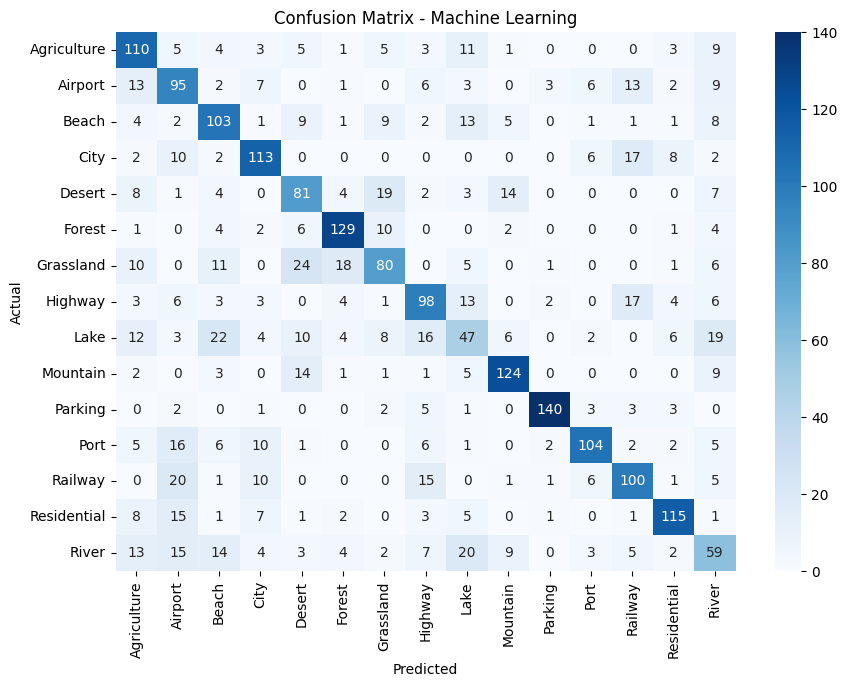

In [3]:
import cv2

import os 

import numpy as np

from sklearn.cluster import MiniBatchKMeans

from ML_SIFT_SVM import SIFT
from k_means_vocb import k_means
from Bow import Bow
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from evaluate import evaluate_model
import matplotlib.pyplot as plt
import seaborn 

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def evaluate_model(y_true, y_pred, model_name):
    print(f"\n -------{model_name} model evaluation--------")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,7))
    seaborn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

def SIFT(path_train):
    # create sift
    sift = cv2.SIFT_create()
    #create dictionary to return result
    # the key is the feature class and value is the descriptor of each feature
    sift_features = {}

    #loop the train folder
    for class_folder in os.listdir(path_train):
        #class_folder is class name not open the folder
        # we need open class first
        class_path = os.path.join(path_train, class_folder)
        if not os.path.isdir(class_path):
            continue
        # store descriptors as value in result
        descriptors_list = []
        
    # loop through imaghe in this class
        for img_file in os.listdir(class_path):
            if img_file.endswith('.jpg'):
                img_path = os.path.join(class_path, img_file)
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                keypoints, descriptors = sift.detectAndCompute(img_gray, None)
                
                if descriptors is not None:
                    descriptors_list.append(descriptors)
        sift_features[class_folder] = descriptors_list

    print("SIFT feature extract completed")
    return sift_features



"""_summary_
for bag of visual words, use k-means clustering to build a visual vocabulary just like vocb in LSTM but is cv
from all descriptors
"""

def k_means(descriptors, num_cluster = 200):
    all_descriptors = []
    
    # cluster all descriptor into one big array
    for des_list in descriptors.values():
        for i in des_list:
            all_descriptors.append(i)
    # stack into a (N,128) array (keypoint, vector)
    # just like zip
    all_descriptors = np.vstack(all_descriptors)
    
    
    # configure the kmean manipulate 
    kmean = MiniBatchKMeans(n_clusters=num_cluster, random_state= 42)
    # build visual vocabulary
    kmean.fit(all_descriptors)
    
    return kmean
    

def compute_bow_histogram(descriptor, kmeans, num_cluster = 200):
    # get vs vocab and get shape
    histogram =  np.zeros(num_cluster)
    if descriptor is not None:
        # predict cluster each SIFT descriptor belong to 
        # count how many items each cluster appears create histogram
        words = kmeans.predict(descriptor)
        for word in words:
            histogram[word] += 1
    
    return histogram

def Bow(descriptors, kmeans, num_cluster = 200):
    x_train = []
    y_train = []
    
    for label, list in descriptors.items():
        for descriptor in list:
            histogram = compute_bow_histogram(descriptor, kmeans, num_cluster)
            x_train.append(histogram)
            y_train.append(label)
    
    return x_train, y_train    
    
    


train_path = os.path.join("dataset","train")
test_path = os.path.join("dataset","test")
num_cluster = 500

# get the SIFT from training dataset
train_descriptors = SIFT(train_path)
test_descriptors = SIFT(test_path)

#create the vocb
kmeans = k_means(train_descriptors, num_cluster)

#get bow of train and test
x_train, y_train = Bow(train_descriptors, kmeans, num_cluster)
x_test, y_test = Bow(test_descriptors, kmeans, num_cluster)

#scale train to standard
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

#train the classificator
clf = SVC(kernel="linear", random_state= 42)
clf.fit(x_train, y_train)

#validation
y_pred = clf.predict(x_test)

evaluate_model(y_test,y_pred,"Machine Learning")
    
    
    